In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base=automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
columns_m = inspector.get_columns('measurement')
for column in columns_m:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
measurement_first = session.query(measurement).first()
measurement_first.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b1aebc0160>,
 'date': '2010-01-01',
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'prcp': 0.08}

In [12]:
# Find the most recent date in the data set.

recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

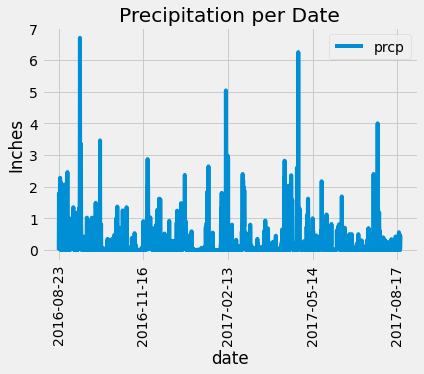

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and 
# plot the results. 

# Starting from the most recent data point in the database. Calculate the date one year from the last date in data set.
year_before = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_before

# Perform a query to retrieve the date and precipitation scores
year_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_before).\
    filter(measurement.date <= dt.date(2017, 8, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(year_data, columns=['date', 'prcp'])
measurement_df.set_index('date', inplace=True)
measurement_df.head()

# Sort the dataframe by date
measurement_df.sort_index(inplace=True)
measurement_df.head()

# Dropping na values
measurement_df.dropna(inplace=True)
measurement_df.head()

# Use Pandas Plotting with Matplotlib to plot the data

measurement_df.plot(title='Precipitation per Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(station).count()
stations

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = session.query(measurement.station, func.min(measurement.tobs),\
                func.max(measurement.tobs), func.avg(measurement.tobs)).\
                filter_by(station = 'USC00519281').all()
top_station

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

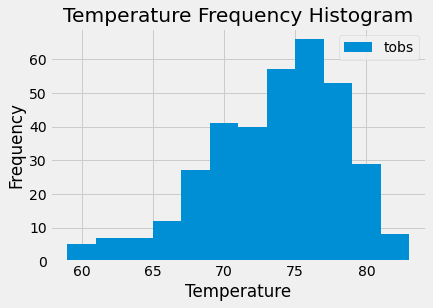

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= year_before).\
    filter(measurement.date <= dt.date(2017, 8, 23)).\
    filter(measurement.station == 'USC00519281').all()

temp_df = pd.DataFrame(temp_data, columns=['date', 'tobs'])
temp_df.set_index('date', inplace=True)


temp_df.plot.hist(bins=12)
plt.title('Temperature Frequency Histogram')
plt.xlabel('Temperature')
plt.show()

# Close session

In [20]:
# Close Session
session.close()